Copyright (c) 2025 Graphcore Ltd. All rights reserved.

# Experiments

Main direct cast quantisation experiments, evaluated on token prediction KL divergence.

In [1]:
%load_ext autoreload
%autoreload 2

import collections
import math
import numpy as np
import re
import scipy.stats
import tqdm
import torch
from torch import tensor, Tensor
from typing import Iterable, Any

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
import pandas as pd
import seaborn as sns

import data_utils as D
import weight_formats.experiments as E
import plot_utils

plot_utils.configure()

def scaled_kl_ratio_label(num: str, denom: str) -> str:
    return f"$\\bar{{\\rho}}^{{\\,({num})}} / \\bar{{\\rho}}^{{\\,({denom})}}$"
def scaled_kl_ratio_label_nomean(num: str, denom: str) -> str:
    return f"$\\rho^{{\\,({num})}} / \\rho^{{\\,({denom})}}$"

Recommend (Ubuntu):
  sudo apt-get install cm-super dvipng fonts-cmu texlive-latex-extra


In [2]:
BASELINES = E.runs("20250506-results-baseline")
WEIGHT_STATS = {r.config.model: r.summary.weight_stats for r in E.runs("20250423-weight-stats")}

RUNS_MAIN = E.runs("20250506-results-main", progress=True)
RUNS_FISHER = E.runs("20250506-results-fisher", progress=True)
RUNS_FISHER_CODE = E.runs("20250506-results-fisher-code", progress=True)
RUNS_HUFFMAN = E.runs("20250506-results-huffman", progress=True)
RUNS_BLOCK_SIZE = E.runs("20250506-results-blocksize", progress=True)
RUNS_SCALE_MANTISSA = E.runs("20250506-results-scalemantissa", progress=True)
RUNS_SYMMETRY = E.runs("20250506-results-symmetry-v2", progress=True)
RUNS_ELEMENT_FORMATS = E.runs("20250506-results-elementformats", progress=True)
RUNS_ALTERNATIVES = E.runs("20250506-results-alternatives", progress=True)
RUNS_ROTATIONS = E.runs("20250506-results-rotations", progress=True)

RUNS = RUNS_MAIN + RUNS_HUFFMAN + RUNS_FISHER + RUNS_FISHER_CODE + RUNS_SYMMETRY + RUNS_BLOCK_SIZE + RUNS_SCALE_MANTISSA + RUNS_ELEMENT_FORMATS + RUNS_ALTERNATIVES + RUNS_ROTATIONS

query: 4680it [00:28, 166.01it/s]
query: 1806it [00:10, 170.30it/s]
query: 585it [00:03, 147.84it/s]
query: 9it [00:00, 117.35it/s]
query: 165it [00:01, 137.11it/s]
query: 264it [00:01, 198.75it/s]
query: 234it [00:01, 143.29it/s]
query: 2442it [00:14, 172.08it/s]
query: 385it [00:02, 188.21it/s]
query: 363it [00:02, 140.19it/s]


### Compute resources

In [8]:
print("Direct-cast experiments")
durations = tensor([r.meta.duration for r in RUNS if r.meta.status == "finished"])
print("  ", len(durations), "runs")
print("  ", f"{durations.mean():.0f}", "seconds / run")
print("  ", f"{durations.sum() / (60*60):.1f}", "hours")

Direct-cast experiments
   10901 runs
   69 seconds / run
   208.4 hours


In [9]:
print("Fisher estimation")
durations = tensor([r.meta.duration for r in E.runs("20250423-fisher") if r.meta.status == "finished"])
print("  ", len(durations), "runs")
print("  ", f"{durations.mean() / 60:.0f}", "minutes / run")
print("  ", f"{durations.sum() / (60*60):.1f}", "hours")

Fisher estimation
   11 runs
   25 minutes / run
   4.6 hours


### Errors

In [10]:
list(run.error.cause.message for run in RUNS if run.meta.status == "failed")

["shape '[151936, 1, 3, 256]' is invalid for input of size 136134656",
 "shape '[151936, 1, 3, 256]' is invalid for input of size 136134656",
 "shape '[151936, 1, 3, 256]' is invalid for input of size 136134656",
 "shape '[262144, 1, 4, 256]' is invalid for input of size 301989888",
 "shape '[262144, 1, 4, 256]' is invalid for input of size 301989888",
 "shape '[262144, 1, 4, 256]' is invalid for input of size 301989888",
 'CUDA out of memory. Tried to allocate 2.00 GiB. GPU 0 has a total capacity of 79.25 GiB of which 604.75 MiB is free. Including non-PyTorch memory, this process has 78.65 GiB memory in use. Of the allocated memory 72.62 GiB is allocated by PyTorch, and 5.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)',
 'CUDA out of memory. Trie

## Main

In [3]:
SELECTED_FORMATS = [
    (dict(element_name="int+Zoptimal", scaling="rms", block="tensor", sparse_ratio=0),
        dict(label="Tensor RMS + Compression", color=plot_utils.PALETTE[0])),
    (dict(element_name="t", scaling="rms", block="tensor", sparse_ratio=2**-10),
        dict(label="Tensor RMS + Sparsity", color=plot_utils.PALETTE[1])),
    (dict(element_name="t", scaling="absmax", block=128, sparse_ratio=0),
        dict(label=r"Block Absmax", color=plot_utils.PALETTE[2])),
]
BAD_FORMATS = [
    (dict(element_name="t", scaling="absmax", block="channel", sparse_ratio=0),
        dict(label="Channel Absmax", color=plot_utils.PALETTE[3])),
    (dict(element_name="t", scaling="absmax", block="tensor", sparse_ratio=0),
        dict(label="Tensor Absmax", color=plot_utils.PALETTE[4])),
    (dict(element_name="t", scaling="rms", block="tensor", sparse_ratio=0),
        dict(label="Tensor RMS", color=plot_utils.PALETTE[5])),
]
SELECTED_LABEL_ORDER = {d["label"]: n for n, (_, d) in enumerate(SELECTED_FORMATS)}


def recalculate_bits_per_param(model: str, param_log: dict[str, Any]) -> float:
    # For Gemma, where the estimate in the logs includes the vision part
    # Note that this is approximate - it excludes layernorm parameters which aren't in weight_stats or param_log
    assert set(WEIGHT_STATS[model]) - {"multi_modal_projector.mm_input_projection_weight"} == set(param_log)
    return sum(param_log[k]["bits"] for k in param_log) / sum(math.prod(WEIGHT_STATS[model][k]["shape"]) for k in param_log)


def get_element_format_name(fmt: E.AttrDict) -> str:
    name = fmt.element_family
    if name == "fp" and "exponent_bits" in fmt.args:
        name = f"{name}-E{fmt.args.exponent_bits:.0f}"
    if name == "t" and "df" in fmt.args:
        name = f"{name}[{fmt.args.df:.0f}]"
    if fmt.compressor is not None:
        if isinstance(fmt.compressor, (list, tuple)):
            compressor = f"+Z{fmt.compressor[0]}|Z{fmt.compressor[1]}"
        else:
            compressor = f"+Z{fmt.compressor}"
        name = f"{name}{compressor}"
    return name


def mean_and_stderr(name: str, data: list[float]) -> dict[str, float]:
    data = tensor(data)
    return {name: data.mean().item(),
            f"{name}_stderr": data.std().item() / len(data)**.5}


def _scaled_fmt(fmt: dict[str, Any]) -> dict[str, Any]:
    return dict(
        element_bits=fmt.element_bits,
        element_family=fmt.element_family,
        element_name=get_element_format_name(fmt),
        element_mode=fmt.args.get("mode", "default"),
        scaling=fmt.scaling,
        scaling_match=fmt.scaling_match,
        scale_mantissa_bits=7 if fmt.scale_format.get("dtype") == "bfloat16" else fmt.scale_format.mantissa_bits,
        block={(None, None): "tensor", (1, None): "channel"}.get(tuple(fmt.block_shape), fmt.block_shape[1]),
        sparse_ratio=fmt.sparse_ratio,
        compression=fmt.compressor == "optimal",
        rotation=bool(fmt.get("rotation") is not None),
    )

def _linear_fmt(fmt: dict[str, Any]) -> dict[str, Any]:
    efmt = fmt.element_format
    if efmt._type == "int":
        element_bits = efmt.bits_
        element_family = element_name = "int"
    if efmt._type == "fp":
        element_bits = 1 + efmt.exponent_bits + efmt.mantissa_bits
        element_family = "fp"
        element_name = f"fp-E{efmt.exponent_bits:.0f}"
    if efmt._type == "lut":
        element_bits = tensor(float(len(efmt.values))).log2().item()
        element_family = element_name = efmt.name.lower()
    return dict(
        element_bits=element_bits,
        element_family=element_family,
        element_name=element_name,
        scaling=fmt.scaling,
        scale_mantissa_bits=7 if fmt.scale_format.get("dtype") == "bfloat16" else fmt.scale_format.mantissa_bits,
        block={(None, None): "tensor", (1, None): "channel"}.get(tuple(fmt.block_shape), fmt.block_shape[1]),
    )

def get_rows() -> Iterable[dict[str, Any]]:
    for run in RUNS:
        test = run.config.test
        if run.meta.status == "finished":
            fmt = test.fmt
            bits_per_param = run.summary.bits_per_param
            if "gemma" in run.config.model:
                bits_per_param = recalculate_bits_per_param(run.config.model, run.summary.params)
            yield dict(
                # Config
                experiment=run.experiment.replace("20250506-results-", ""),
                model=run.config.model.split("/")[1],
                **(_scaled_fmt(fmt) if fmt._type == "fit_scaled" else _linear_fmt(fmt)),
                allocation=test.type.replace("quantise_", ""),
                error_weight=test.error_weight or "none",
                # Outcome
                **mean_and_stderr("kl_div", run.summary.kl_div),
                **mean_and_stderr("cross_entropy", run.summary.cross_entropy),
                bits_per_param=bits_per_param,
            )


df = pd.DataFrame.from_records(get_rows())
df["kl_div_efficiency"] = df.kl_div * 2**(2*df.bits_per_param)
df["kl_div_efficiency_stderr"] = df.kl_div_stderr * 2**(2*df.bits_per_param)
for select, args in SELECTED_FORMATS:
    df.loc[D.select(df, select).index, "selected_label"] = args["label"]

print("model:", list(df.model.unique()))
print("element_name:", list(df.element_name.unique()))
print("experiment:", list(df.experiment.unique()))

assert df.groupby(
    ["experiment", "model", "element_bits", "element_name", "element_mode", "scaling", "scaling_match", "block", "sparse_ratio", "allocation", "error_weight"]
).apply(len, include_groups=False).max() == 1

# Best over "element_mode"
dfb = D.best(df, "kl_div", ["experiment", "model", "element_bits", "element_name", "scaling", "scaling_match", "block", "sparse_ratio", "allocation", "error_weight"])

display(df.head())

model: ['Llama-3.1-8B', 'Llama-3.2-1B', 'Llama-3.2-3B', 'phi-4', 'Qwen2.5-0.5B', 'Qwen2.5-1.5B', 'Qwen2.5-3B', 'Qwen2.5-7B', 'gemma-3-1b-pt', 'gemma-3-4b-pt', 'gemma-3-12b-pt']
element_name: ['int+Zoptimal', 'int', 't', 'int+Zhuffman|Zoptimal', 'normal', 'laplace', 't[30]', 'lloyd_max', 'fp-E2', 'nf', 'sf_df5']
experiment: ['main', 'huffman', 'fisher', 'fisher-code', 'symmetry-v2', 'blocksize', 'scalemantissa', 'elementformats', 'alternatives', 'rotations']


,experiment,model,element_bits,element_family,element_name,element_mode,scaling,scaling_match,scale_mantissa_bits,block,...,allocation,error_weight,kl_div,kl_div_stderr,cross_entropy,cross_entropy_stderr,bits_per_param,kl_div_efficiency,kl_div_efficiency_stderr,selected_label
0,main,Llama-3.1-8B,3.0,int,int+Zoptimal,default,rms,search,7.0,64.0,...,fixed,none,0.190885,0.003281,1.977858,0.018411,3.254851,17.393549,0.298957,NaN
1,main,Llama-3.1-8B,3.0,int,int+Zoptimal,default,rms,search,7.0,64.0,...,fixed,none,0.183496,0.003172,1.970641,0.018329,3.630242,28.135272,0.486339,NaN
2,main,Llama-3.1-8B,3.0,int,int+Zoptimal,default,rms,search,7.0,channel,...,fixed,none,0.197449,0.003325,1.984892,0.018422,3.000388,12.643543,0.212919,NaN
3,main,Llama-3.1-8B,3.0,int,int+Zoptimal,default,rms,search,7.0,channel,...,fixed,none,0.175126,0.003084,1.961779,0.018403,3.374730,18.842598,0.331871,NaN
4,main,Llama-3.1-8B,3.0,int,int+Zoptimal,default,rms,search,7.0,channel,...,fixed,none,0.178511,0.003273,1.965637,0.018308,3.056604,12.357307,0.226592,NaN


### `xp_tradeoff_overview`

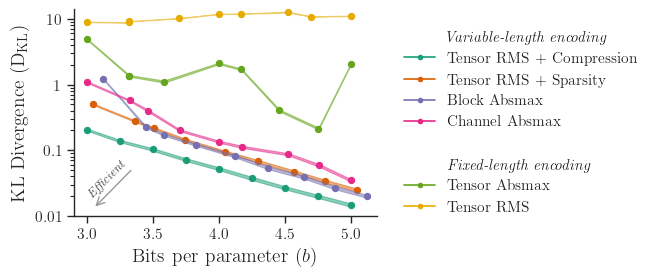

In [7]:
tradeoff_d = (D.select(dfb, dict(experiment="main"))
    .pipe(lambda d: d[~((d.scaling == "rms") & (d.block != "tensor") & (d.sparse_ratio != 0))])
    .pipe(lambda d: d.assign(block_absmax=((~d.block.isin(["tensor", "channel"])) & (d.scaling == "absmax"))))
)

_, ax = plt.subplots(figsize=(6.5, 3))

for select, args in SELECTED_FORMATS + BAD_FORMATS:
    g = D.select(tradeoff_d, dict(**select, model="Llama-3.1-8B"))
    y = "kl_div"
    ax.fill_between(g.bits_per_param, g[y] - 2*g[f"{y}_stderr"], g[y] + 2*g[f"{y}_stderr"], **args, alpha=.5)
    ax.scatter(g.bits_per_param, g[y], **args, s=20)

ax.set_yscale("log")
ax.yaxis.set_major_formatter(lambda x, _: f"{x:.0f}" if x >= 1 else str(x))
ax.set_xlabel("Bits per parameter ($b$)")
ax.set_ylabel(f"KL Divergence ({plot_utils.display_name("kl_div")})")

ax.annotate(r"\textit{Efficient}", (3.31, 0.036), ha="right", va="center", fontsize=9, arrowprops=dict(arrowstyle="->", lw=2), color="#444", rotation=45)
ax.annotate(r"", (3.05, 0.013), xytext=(3.35, 0.053), textcoords="data", arrowprops=dict(arrowstyle="->", color="#999", lw=1))

plot_utils.set_figure_legend(ax.figure, build=[
    r"\textit{Variable-length encoding}",
    *(dict(**d, marker="o") for _, d in SELECTED_FORMATS + BAD_FORMATS[:1]),
    "",
    r"\textit{Fixed-length encoding}",
    *(dict(**d, marker="o") for _, d in BAD_FORMATS[1:]),
])
ax.set_ylim((10**-2, 14))
ax.set_xlim((2.9, 5.2))
plot_utils.tidy(ax.figure)
plot_utils.save("xp_tradeoff_overview_llama8b")

remote: Updating references: 100% (1/1)           


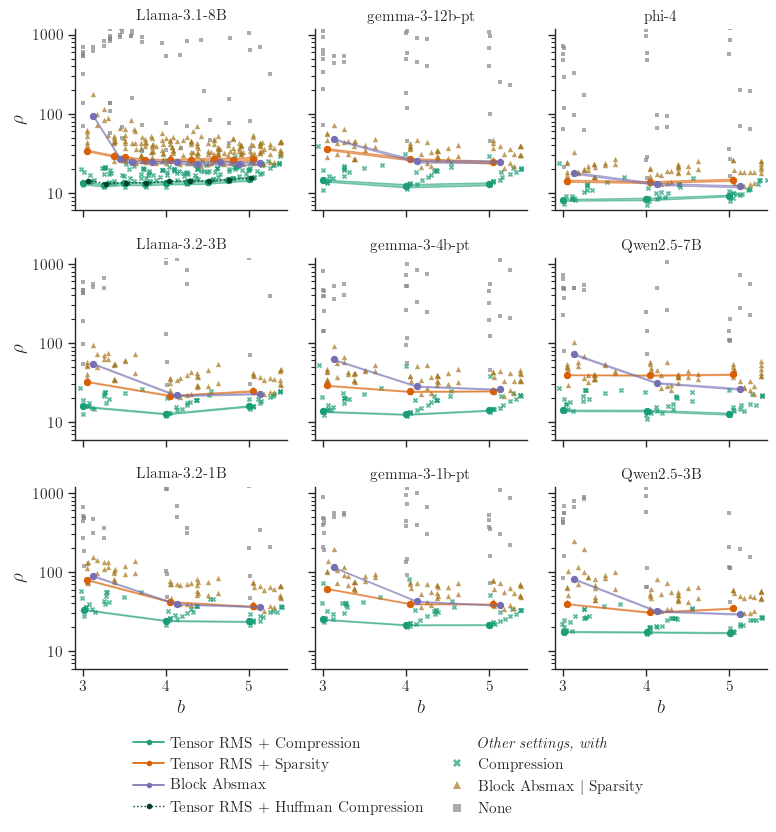

In [5]:
figw, figh = matplotlib.rcParams["figure.figsize"]
_, axs = plt.subplots(nrows=3, ncols=3, figsize=(figw, 2.5 * figh), sharey=True, sharex=True)

tradeoff_d = (D.select(dfb, dict(experiment="main"))
    .pipe(lambda d: d[~((d.scaling == "rms") & (d.block != "tensor") & (d.sparse_ratio != 0))])
    .pipe(lambda d: d.assign(block_absmax=((~d.block.isin(["tensor", "channel"])) & (d.scaling == "absmax"))))
)

for model, ax in zip(plot_utils.MODEL_ORDER_GRID, axs.flatten()):
    d = tradeoff_d[tradeoff_d.model == model]
    y = "kl_div_efficiency"
    points = [
        (d.compression, dict(color=plot_utils.PALETTE[0], marker="X", s=15, label="Compression")),
        (~d.compression & (d.block_absmax | d.sparse_ratio), dict(color=plot_utils.PALETTE[6], marker="^", s=15, label="Block Absmax $|$ Sparsity")),
        (~(d.compression | d.block_absmax | d.sparse_ratio), dict(color="#888", marker="s", s=10, label="None")),
    ]
    for select, args in SELECTED_FORMATS:
        g = D.select(d, select)
        ax.fill_between(g.bits_per_param, g[y] - 2*g[f"{y}_stderr"], g[y] + 2*g[f"{y}_stderr"], **args, alpha=.5)
        ax.scatter(g.bits_per_param, g[y], **args, s=20)

    for filter, args in points:
        d[filter].pipe(lambda g: ax.scatter(g.bits_per_param, g[y], **args, zorder=-1, alpha=.7, lw=0))

    ax.set_yscale("log")
    ax.yaxis.set_major_formatter(lambda x, _: f"{x:.0f}" if x >= 1 else str(x))
    ax.set_xlabel("$b$")
    ax.set_ylabel("kl_div_efficiency")
    ax.set_title(model)

for ax in axs[:, 1:].flatten():
    ax.set_ylabel("")
for ax in axs[:-1, :].flatten():
    ax.set_xlabel("")

huffman_args = dict(marker="o", ls=":", lw=1, color="#042", label="Tensor RMS + Huffman Compression")
d = D.select(df, dict(experiment="huffman", scaling="rms", block="tensor", sparse_ratio=0))
assert set(d.model) == {plot_utils.MODEL_ORDER_GRID[0]}
axs[0, 0].plot(d.bits_per_param, d.kl_div_efficiency, **huffman_args)

axs[0, 0].set_ylim((6e0, 1.2e3))
axs[0, 0].set_xlim((2.9, 5.45))

plot_utils.set_figure_legend(
    axs[0, 0].figure, build=[
        *[dict(**d, marker="o") for _, d in SELECTED_FORMATS],
        huffman_args,
        r"\textit{Other settings, with}",
        *[dict(**D.drop(d, "s"), lw=0, ms=6, alpha=.7, mew=0) for _, d in points],
    ],
    bbox_to_anchor=(0.0, 0.02, 1.0, 0), loc="upper center", ncols=2, columnspacing=1.25, handletextpad=0.4
)

plot_utils.tidy(axs[0, 0].figure)
plot_utils.save("xp_tradeoff_overview_grid")

### `xp_compression_scaling`

remote: Updating references: 100% (1/1)           


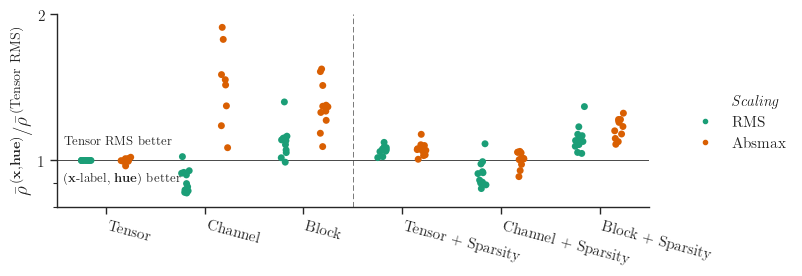

In [191]:
def block_sparse_name(s: pd.Series) -> str:
    name = ["Block" if isinstance(s.block, float) else s.block.capitalize()]
    if s.sparse_ratio:
        name += ["+ Sparsity"]
    return " ".join(name)

d = (D.select(dfb, dict(experiment="main", compression=True), drop=False)
 .groupby(["model", "block", "scaling", "sparse_ratio"])[["kl_div_efficiency"]].mean().reset_index()
 .pipe(lambda d: d.assign(block_sparse=d.apply(block_sparse_name, axis=1)))
 .pipe(lambda d: D.best(d, "kl_div_efficiency", ["model", "scaling", "block_sparse"]))
 .groupby(["model"]).apply(
    lambda g: g.assign(kl_div_efficiency_delta=g.kl_div_efficiency / D.select(g, dict(block="tensor", scaling="rms", sparse_ratio=0)).kl_div_efficiency.iloc[0]), include_groups=False)
)

block_sparse = ["Tensor", "Channel", "Block", "Tensor + Sparsity", "Channel + Sparsity", "Block + Sparsity"]
assert set(d.block_sparse.unique()) == set(block_sparse)
scaling = dict(rms="RMS", absmax="Absmax")

_, ax = plt.subplots()
sns.stripplot(data=d, y="kl_div_efficiency_delta", x="block_sparse", order=block_sparse,
              hue="scaling", hue_order=scaling.keys(), palette=plot_utils.PALETTE[:len(scaling)],
              dodge=True, ax=ax)
ax.set_yscale("log")
ax.set_yticks([1, 2], [1, 2])
ax.tick_params(which="minor", labelleft=False)
ax.set_ylim((0.8, 2))
ax.axhline(1, color="k", lw=0.5)
ax.annotate("Tensor RMS better", (-0.5, 1), (5, 10), textcoords="offset points", ha="left", va="bottom", fontsize=9)
ax.annotate(r"(\textbf{x}-label, \textbf{hue}) better", (-0.5, 1), (5, -8), textcoords="offset points", ha="left", va="top", fontsize=9)
ax.set_xticks(torch.arange(len(block_sparse)).tolist(), block_sparse, ha="left", rotation=-15, fontsize=11);

ax.axvline(2.5, color="#444", lw=0.5, ls="--", dashes=(8, 4))
ax.set_xlabel("")
ax.set_ylabel(scaled_kl_ratio_label(r"\textbf{x}, \textbf{hue}", r"\text{Tensor RMS}"))
ax.legend_.remove()
plot_utils.set_figure_legend(ax.figure, build=[
    r"\textit{Scaling}", *(dict(label=v, color=c, marker="o", lw=0) for v, c in zip(scaling.values(), plot_utils.PALETTE))], bbox_to_anchor=(0.92, 0.55))

plot_utils.tidy(ax.figure)
plot_utils.save("xp_compression_scaling")

### `xp_bit_allocation`

Note [xp_bit_allocation]: variable allocation degrades: {'Qwen2.5-3B': 1, 'gemma-3-12b-pt': 3, 'gemma-3-1b-pt': 3, 'gemma-3-4b-pt': 3}


remote: Updating references: 100% (1/1)           


Note [xp_bit_allocation_code]: variable allocation degrades: {'Llama-3.1-8B': 1, 'Qwen2.5-1.5B': 1, 'Qwen2.5-3B': 1, 'Qwen2.5-7B': 1, 'gemma-3-12b-pt': 3, 'gemma-3-1b-pt': 3, 'gemma-3-4b-pt': 3}


remote: Updating references: 100% (1/1)           


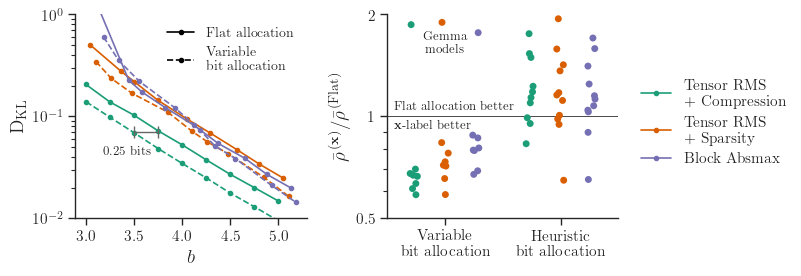

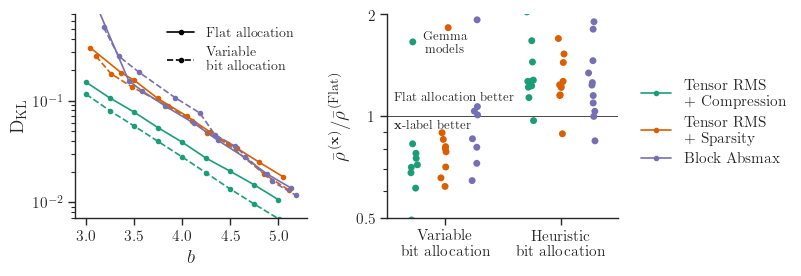

In [185]:
allocations = [
    ("fixed", dict(ls="-", marker="o", label="Flat allocation")),
    ("variable", dict(ls="--", marker="o", label="Variable\nbit allocation")),
]

for name, experiments in [("xp_bit_allocation", ["main", "fisher"]), ("xp_bit_allocation_code", "fisher-code")]:
    _, (ax0, ax1) = plt.subplots(ncols=2)

    # Tradeoff plot
    d = (D.select(dfb, dict(model="Llama-3.1-8B", experiment=experiments, allocation=["fixed", "variable", "heuristic"], error_weight="none")))
    for s, args in SELECTED_FORMATS:
        for a, aargs in allocations:
            g = D.select(d, dict(**s, allocation=a))
            ax0.plot(g.bits_per_param, g.kl_div, **args, **plot_utils.drop_label(aargs))
    if name == "xp_bit_allocation":
        ax0.plot([3.5, 3.75], [0.07, 0.07], color="#666", marker="|", ms=9, linewidth=1, mew=1, zorder=100)
        ax0.annotate("$0.25$ bits", (3.5, 0.07), (-5, -10), textcoords="offset points", ha="center", va="top", fontsize=9)

    ax0.set_xlabel("bits_per_param")
    ax0.set_ylabel("kl_div")
    ax0.set_yscale("log")
    ax0.set_ylim((7e-3, 7e-1) if experiments == "fisher-code" else (1e-2, 1))

    ax0.legend(handles=plot_utils.build_legend_handles(*allocations), fontsize=10)

    # Across-models plot
    d = (D.select(dfb, dict(experiment=experiments, allocation=["fixed", "variable", "heuristic"], error_weight="none"))
        .groupby(["model", "selected_label", "allocation"])[["kl_div_efficiency"]].mean().reset_index()
        .groupby(["model", "selected_label"]).apply(
            lambda g: g.assign(kl_div_efficiency_delta=g.kl_div_efficiency / g.kl_div_efficiency[g.allocation=="fixed"].iloc[0]), include_groups=False)
        .reset_index()
    )
    sns.stripplot(data=d[d.allocation != "fixed"], y="kl_div_efficiency_delta", x="allocation",
                hue="selected_label", order=["variable", "heuristic"],
                hue_order=[d["label"] for _, d in SELECTED_FORMATS], dodge=True, ax=ax1)

    ax1.tick_params(which="minor", labelleft=False)
    ax1.annotate("Gemma\nmodels", (0, 1.78), ha="center", va="top", fontsize=9)
    ax1.axhline(1, color="k", lw=0.5)
    ax1.annotate(r"Flat allocation better", (-0.5, 1), (5, 9 if experiments == "fisher-code" else 3), textcoords="offset points", ha="left", va="bottom", fontsize=9)
    ax1.annotate(r"\textbf{x}-label better", (-0.5, 1), (5, -3), textcoords="offset points", ha="left", va="top", fontsize=9)

    ax1.set_yscale("log")
    ax1.set_yticks([0.5, 1, 2])
    ax1.set_yticklabels([0.5, 1, 2])
    ax1.set_ylim((0.5, 2))

    ax1.legend_.remove()
    ax1.set_xlabel("")
    ax1.set_xticks([0, 1])
    ax1.set_xticklabels(["Variable\nbit allocation", "Heuristic\nbit allocation"])
    ax1.set_ylabel(scaled_kl_ratio_label(r"\textbf{x}", r"\text{Flat}"))

    plot_utils.set_figure_legend(ax0.figure, build=[
        (dict(**d, marker="o"),) for _, d in plot_utils.transform_labels(SELECTED_FORMATS, " + ", "\n+ ")
    ])

    print(f"Note [{name}]: variable allocation degrades:",
        dict(collections.Counter(d[(d.kl_div_efficiency_delta > 1) & (d.allocation == "variable")].model)))

    plot_utils.tidy(ax0.figure)
    plot_utils.save(name)

### `xp_block_size_scale_mantissa`

remote: Updating references: 100% (1/1)           


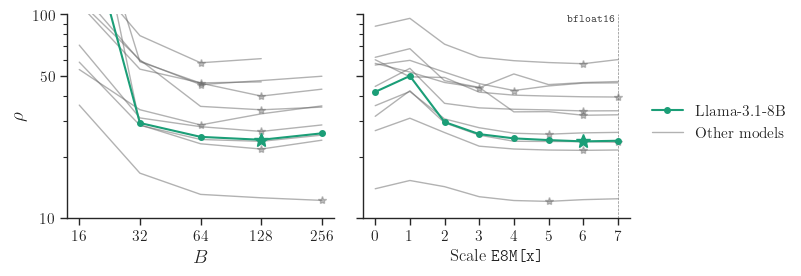

In [ ]:
_, (ax0, ax1) = plt.subplots(ncols=2, sharey=True)

# We didn't end up using target_bits = [3, 5] from the experiment
d0 = (D.select(dfb, dict(experiment="blocksize"))
    .pipe(lambda d: d.assign(block=d.block.astype(float)))
    .pipe(lambda d: d.assign(target_bits=d.element_bits + 16 / d.block))
    .pipe(lambda d: d[d.target_bits == 4])
    .sort_values("block")
)
d1 = (D.select(dfb, dict(experiment="scalemantissa"))
    .pipe(lambda d: d.assign(target_bits=d.element_bits + (d.scale_mantissa_bits + 8) / d.block.astype(float)))
    .pipe(lambda d: d[d.target_bits == 4])
    .sort_values("scale_mantissa_bits")
)

models_args = [
    ({"Llama-3.1-8B"}, dict(lw=1.5, marker="o", ms=4, color=plot_utils.PALETTE[0], zorder=10, label="Llama-3.1-8B")),
    (set(dfb.model.unique()) - {"Llama-3.1-8B"}, dict(lw=1, alpha=.5, color=plot_utils.PALETTE[7], label="Other models")),
]
for x, d, ax in [("block", d0, ax0), ("scale_mantissa_bits", d1, ax1)]:
    for models, args in models_args:
        for model in models:
            g = d[d.model == model]
            ax.plot(g[x], g.kl_div_efficiency, **args)
            gmin = g.loc[g.kl_div_efficiency.idxmin()]
            ax.plot(gmin[x], gmin.kl_div_efficiency, marker="*", color=args["color"], zorder=args.get("zorder"),
                    **(dict(ms=10) if model == "Llama-3.1-8B" else dict(alpha=.4, ms=6)))

ax0.set_yscale("log")
ax0.set_ylabel("kl_div_efficiency")
ax0.yaxis.set_major_formatter("{x:.0f}")
ax0.set_ylim((10, 100))
ax0.set_yticks([10, 50, 100])
ax0.tick_params(which="minor", labelleft=False)

ax0.set_xscale("log", base=2)
ax0.set_xlabel("block_size")
ax0.xaxis.set_major_formatter("{x:.0f}")

ax1.axvline(7, color="#888", lw=0.5, ls="--", zorder=0)
ax1.annotate(r"\texttt{bfloat16}", [7, 100], va="top", ha="right", fontsize=8, color="#444",
             xytext=(-3, 0), textcoords="offset points")

ax1.set_xticks(list(range(8)))
ax1.set_xlabel(r"Scale \texttt{E8M[x]}", fontsize=12)

plot_utils.set_figure_legend(ax0.figure, build=models_args)

plot_utils.tidy(ax0.figure)
plot_utils.save("xp_block_size_scale_mantissa")

### `xp_moment_matching_vs_search`

Note: very bad (rms) {}
Note: very bad (absmax) {'Qwen2.5-3B': 7}


remote: Updating references: 100% (1/1)           


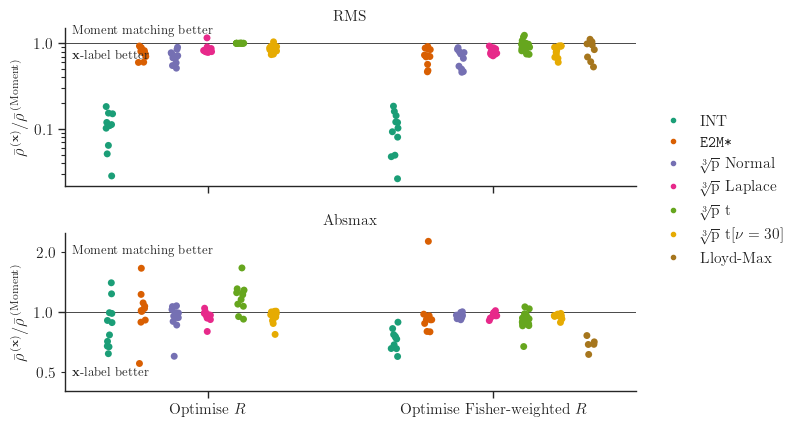

In [192]:
elements = {
    "int": "INT",
    "fp-E2": r"\texttt{E2M*}",
    "normal": plot_utils.CRD_LABEL + " Normal",
    "laplace": plot_utils.CRD_LABEL + " Laplace",
    "t": plot_utils.CRD_LABEL + " t",
    "t[30]": plot_utils.CRD_LABEL + r" t[$\nu=30$]",
    "lloyd_max": "Lloyd-Max",
}
searches = dict(none="Optimise $R$", fisher="Optimise Fisher-weighted $R$")

grid = plot_utils.grid(["rms", "absmax"], height=2.25, sharex=True)
for (scaling,), ax in grid:
    d = (D.select(dfb, dict(experiment=["symmetry", "elementformats"], scaling=scaling), drop=False)
        .groupby(["model", "element_name", "scaling_match", "error_weight"])[["kl_div_efficiency"]].mean().reset_index()
        .groupby(["model", "element_name"])
            .apply(lambda d: d.assign(kl_div_efficiency_delta=d.kl_div_efficiency
                                      / D.select(d, dict(scaling_match="search" if d.name[1] == "lloyd_max" else "moments", error_weight="none")).kl_div_efficiency.iloc[0]
                   ), include_groups=False)
        .reset_index()
        .pipe(lambda d: d[~((d.scaling_match == "moments") & (d.error_weight == "none"))])
        .pipe(lambda d: d[~((d.element_name == "lloyd_max") & (d.error_weight == "none"))])
    )
    sns.stripplot(data=d, y="kl_div_efficiency_delta", x="error_weight", order=searches, hue="element_name", hue_order=elements,
                  dodge=True, palette=plot_utils.PALETTE[:len(elements)], ax=ax)

    ax.set_yscale("log")
    ax.axhline(1, color="k", lw=0.5)
    ax.annotate("Moment matching better", (-0.5, 1), (5, dict(rms=5, absmax=40)[scaling]), textcoords="offset points", ha="left", va="bottom", fontsize=9)
    ax.annotate(r"\textbf{x}-label better", (-0.5, 1), (5, dict(rms=-5, absmax=-40)[scaling]), textcoords="offset points", ha="left", va="top", fontsize=9)

    ax.set_xlabel("")
    ax.set_ylabel(scaled_kl_ratio_label(r"\textbf{x}", r"\text{Moment}"), fontsize=12)
    ax.yaxis.set_major_formatter("{x:.1f}")
    if scaling == "absmax":
        ax.set_yticks([0.5, 2], [0.5, 2], minor=True)
        ax.yaxis.set_minor_formatter("{x:.1f}")
    ax.set_xticks(list(range(len(searches))), searches.values())
    ax.legend_.remove()
    ax.set_title(scaling)
    if scaling == "absmax":
        ax.set_ylim((0.4, 2.5))

    print(f"Note: very bad ({scaling})", dict(collections.Counter(d[(d.kl_div_efficiency_delta > 2) & (d.error_weight == "fisher")].model)))

plot_utils.set_figure_legend(grid.figure, build=[dict(marker="o", lw=0, label=x, color=color) for x, color in zip(elements.values(), plot_utils.PALETTE)])
plot_utils.tidy(grid.figure)
plot_utils.save("xp_moment_matching_vs_search")

### `xp_element_formats`

remote: Updating references: 100% (1/1)           


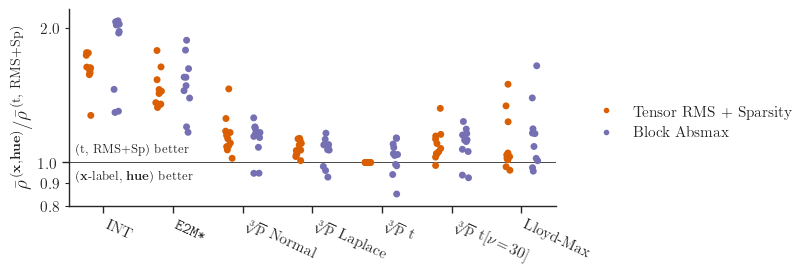

In [194]:
elements = {
    "int": "INT",
    "fp-E2": r"\texttt{E2M*}",
    "normal": plot_utils.CRD_LABEL + " Normal",
    "laplace": plot_utils.CRD_LABEL + " Laplace",
    "t": plot_utils.CRD_LABEL + " t",
    "t[30]": plot_utils.CRD_LABEL + r" t[$\nu\!=\!30$]",
    "lloyd_max": "Lloyd-Max",
}
scaling = [
    ("rms", dict(label="Tensor RMS + Sparsity", color=plot_utils.PALETTE[1])),
    ("absmax", dict(label=r"Block Absmax", color=plot_utils.PALETTE[2])),
]

d = (D.select(dfb, dict(experiment=["symmetry", "elementformats"]), drop=False)
    .groupby(["model", "element_name", "scaling", "scaling_match", "error_weight"])[["kl_div_efficiency"]].mean().reset_index()
    .pipe(lambda d: D.best(d, "kl_div_efficiency", ["model", "element_name", "scaling"]))
    .groupby(["model"])
        .apply(lambda d: d.assign(kl_div_efficiency_delta=d.kl_div_efficiency / d[(d.element_name == "t") & (d.scaling == "rms")].kl_div_efficiency.iloc[0]), include_groups=False)
    .reset_index()
)
_, ax = plt.subplots()
sns.stripplot(data=d, y="kl_div_efficiency_delta", x="element_name", hue="scaling", dodge=True,
              order=elements, hue_order=[s for s, _ in scaling], palette=[d["color"] for _, d in scaling], ax=ax)

ax.set_yscale("log")
ax.axhline(1, color="k", lw=0.5)
ax.annotate("(t, RMS+Sp) better", (-0.5, 1), (5, 5), textcoords="offset points", ha="left", va="bottom", fontsize=9)
ax.annotate(r"(\textbf{x}-label, \textbf{hue}) better", (-0.5, 1), (5, -5), textcoords="offset points", ha="left", va="top", fontsize=9)

ax.set_xlabel("")
ax.set_ylabel(scaled_kl_ratio_label(r"\textbf{x},\textbf{hue}", r"\text{t, RMS+Sp}"))
ax.yaxis.set_major_formatter("{x:.1f}")
ax.yaxis.set_minor_formatter("{x:.1f}")
ax.set_ylim((0.8, 2.2))
ax.set_xticks(list(range(len(elements))), elements.values(), rotation=-25, ha="left", fontsize=11)
ax.legend_.remove()

plot_utils.set_figure_legend(ax.figure, build=[(dict(marker="o", lw=0, **d),) for _, d in scaling], bbox_to_anchor=(0.94, 0.55))
plot_utils.tidy(ax.figure)
plot_utils.save("xp_element_formats")

### `xp_alternatives_block_size`

remote: Updating references: 100% (1/1)           


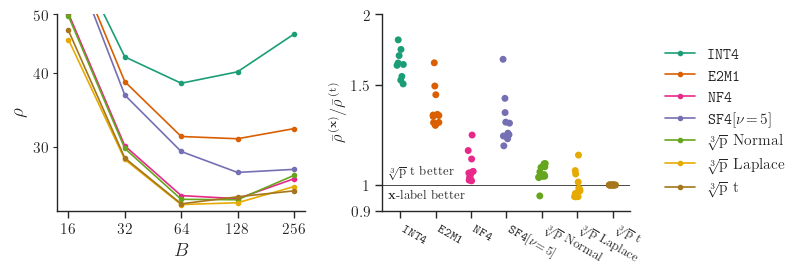

In [195]:
_, (ax0, ax1) = plt.subplots(ncols=2)

args = dict(marker="o")
alternatives = [
    ("int", dict(label=r"\texttt{INT4}", color=plot_utils.PALETTE[0])),
    ("fp-E2", dict(label=r"\texttt{E2M1}", color=plot_utils.PALETTE[1])),
    ("nf", dict(label=r"\texttt{NF4}", color=plot_utils.PALETTE[3])),
    ("sf_df5", dict(label=r"\texttt{SF4}[$\nu\!=\!5$]", color=plot_utils.PALETTE[2])),
    ("normal", dict(label=f"{plot_utils.CRD_LABEL} Normal", color=plot_utils.PALETTE[4])),
    ("laplace", dict(label=f"{plot_utils.CRD_LABEL} Laplace", color=plot_utils.PALETTE[5])),
    ("t", dict(label=f"{plot_utils.CRD_LABEL} t", color=plot_utils.PALETTE[6])),
]

d = D.select(df, dict(experiment="alternatives", model="Llama-3.1-8B"))
for a, aargs in alternatives:
    g = D.select(d, dict(element_name=a))
    ax0.plot(g.block, g.kl_div_efficiency, **args, **aargs)

ax0.set_xscale("log", base=2)
ax0.set_yscale("log")
ax0.set_ylim((23.5, 50))

ax0.set_xlabel("block_size")
ax0.set_ylabel("kl_div_efficiency")
ax0.xaxis.set_major_formatter("{x:.0f}")
ax0.yaxis.set_minor_formatter("{x:.0f}")

d = (D.select(df, dict(experiment=["alternatives"]), drop=False)
    .groupby(["model", "element_name"])[["kl_div_efficiency"]].mean().reset_index()
    .groupby(["model"])
        .apply(lambda d: d.assign(kl_div_efficiency_delta=d.kl_div_efficiency / d[(d.element_name == "t")].kl_div_efficiency.iloc[0]), include_groups=False)
    .reset_index()
)
sns.stripplot(data=d, y="kl_div_efficiency_delta", x="element_name", hue="element_name",
              order=[a for a, _ in alternatives], hue_order=[a for a, _ in alternatives],
              palette=[d["color"] for _, d in alternatives], ax=ax1)
ax1.axhline(1, color="k", lw=0.5)
ax1.set_yscale("log")
ax1.set_ylim((0.9, 2))
ax1.set_yticks([0.9, 1, 1.5, 2], [0.9, 1, 1.5, 2])
ax1.set_xticklabels([])
ax1.set_xlabel("")
ax1.set_ylabel(scaled_kl_ratio_label(r"\textbf{x}", r"\mathrm{t}"), fontsize=12)
ax1.set_xticks(torch.arange(len(alternatives)).tolist(), [d["label"] for _, d in alternatives], rotation=-30, ha="left", fontsize=9)

ax1.annotate(f"{plot_utils.CRD_LABEL} t better", (-0.5, 1), (4, 4), textcoords="offset points", ha="left", va="bottom", fontsize=9)
ax1.annotate(r"\textbf{x}-label better", (-0.5, 1), (4, -4), textcoords="offset points", ha="left", va="top", fontsize=9)

plot_utils.set_figure_legend(ax0.figure, build=[(dict(**args, **d),) for _, d in alternatives], bbox_to_anchor=(0.98, 0.55))
plot_utils.tidy(ax0.figure)
plot_utils.save("xp_alternatives_block_size")

### `xp_signmax`

remote: Updating references: 100% (1/1)           


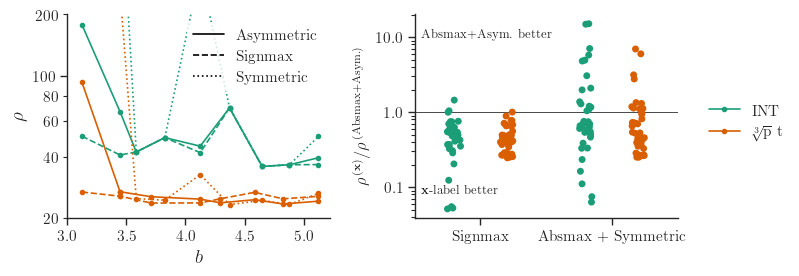

In [196]:
_, (ax0, ax1) = plt.subplots(ncols=2)

# Tradeoff plot

d = (D.select(df, dict(model="Llama-3.1-8B", experiment="symmetry-v2"))
    .pipe(lambda d: d.assign(scaling_mode=d.apply(lambda s: "signmax" if s.scaling == "signmax" else s.element_mode, axis=1)))
    .sort_values("element_bits")
)
elements = [
    ("int", dict(marker="o", label="INT", color=plot_utils.PALETTE[0])),
    ("t", dict(marker="o", label=plot_utils.CRD_LABEL + " t", color=plot_utils.PALETTE[1])),
]
scalings = [
    ("asymmetric", dict(label="Asymmetric", ls="-")),
    ("signmax", dict(label="Signmax", ls="--")),
    ("symmetric", dict(label="Symmetric", ls=":")),
]
for scaling, sargs in scalings:
    for element, eargs in elements:
        g = d[(d.scaling_mode == scaling) & (d.element_family == element)]
        ax0.plot(g.bits_per_param, g.kl_div_efficiency, **sargs, **plot_utils.drop_label(eargs))

ax0.set_xticks(torch.arange(3, 5.5, 0.5))
ax0.set_yscale("log")
ax0.set_ylim((20, 200))
ax0.set_yticks([20, 40, 60, 80, 200], [20, 40, 60, 80, 200], minor=True)

ax0.yaxis.set_major_formatter("{x:.0f}")
ax0.set_xlabel("bits_per_param")
ax0.set_ylabel("kl_div_efficiency")
ax0.legend(handles=plot_utils.build_legend_handles(*scalings), loc="upper right")

# Across-models plot
d = (D.select(df, dict(experiment="symmetry-v2"))
    .pipe(lambda d: d.assign(scaling_mode=d.apply(lambda s: "signmax" if s.scaling == "signmax" else s.element_mode, axis=1)))
    .groupby(["model", "element_family"]).apply(
        lambda g: g.assign(kl_div_efficiency_delta=g.kl_div_efficiency / g.kl_div_efficiency[g.scaling_mode=="asymmetric"].iloc[0]), include_groups=False)
    .reset_index()
    .pipe(lambda d: d[d.scaling_mode != "asymmetric"])
)
sns.stripplot(data=d, y="kl_div_efficiency_delta", x="scaling_mode", order=[s for s, _ in scalings[1:]],
              hue="element_family", hue_order=[e for e, _ in elements], dodge=True, ax=ax1)

ax1.axhline(1, color="k", lw=0.5)
ax1.annotate("Absmax+Asym. better", (-0.5, 9), (5, 0), textcoords="offset points", ha="left", va="bottom", fontsize=9)
ax1.annotate(r"\textbf{x}-label better", (-0.5, 0.12), (5, -3), textcoords="offset points", ha="left", va="top", fontsize=9)

ax1.set_yscale("log")
ax1.yaxis.set_major_formatter("{x:.1f}")

ax1.legend_.remove()
ax1.set_xlabel("")
ax1.set_xticks([0, 1], ["Signmax", "Absmax + Symmetric"])
ax1.set_ylabel(scaled_kl_ratio_label_nomean(r"\textbf{x}", r"\text{Absmax+Asym.}"), fontsize=12)

plot_utils.set_figure_legend(ax0.figure, build=elements, bbox_to_anchor=(0.98, 0.55))
plot_utils.tidy(ax0.figure)
plot_utils.save("xp_signmax")

### `xp_rotations`

Bad performance with rotations {'phi-4': 1}
Note Phi-4 shapes:  {(5120.0, 5120.0): 40, (7680.0, 5120.0): 40, (5120.0, 17920.0): 40, (35840.0, 5120.0): 40, (100352.0, 5120.0): 2}


remote: Updating references: 100% (1/1)           


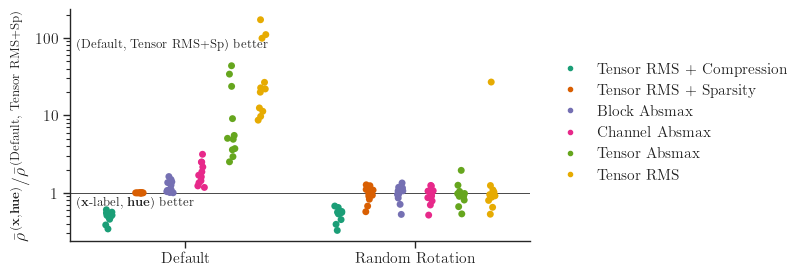

In [204]:
_, ax = plt.subplots()

formats = SELECTED_FORMATS + BAD_FORMATS
rotations = [
    (False, dict(label="Default")),
    (True, dict(label="Random Rotation")),
]

# A hacky way to build the dataframe
def relative_perfs() -> Iterable[dict[str, Any]]:
    for model in dfb.model.unique():
        d = D.select(dfb, dict(experiment=["main", "rotations"], model=model, element_bits=[3,4,5]))
        baseline = D.select(d, SELECTED_FORMATS[1][0])
        assert len(baseline) == 3
        for select, args in formats:
            select = select.copy()
            if select["element_name"] == "t":
                select["element_name"] = ["normal", "t"]
            for rotation, _ in rotations:
                g = D.select(d, dict(**select, rotation=rotation))
                assert len(g) == 3
                delta = g.kl_div_efficiency.mean() / baseline.kl_div_efficiency.mean()
                yield dict(model=model, format=args["label"], rotation=rotation, kl_div_efficiency_delta=delta)
d = pd.DataFrame.from_records(relative_perfs())
print("Bad performance with rotations", d[(d.rotation) & (d.kl_div_efficiency_delta > 10)].model.value_counts().to_dict())
print("Note Phi-4 shapes: ", dict(collections.Counter(tuple(w.shape) for _, w in WEIGHT_STATS["microsoft/phi-4"].items())))

sns.stripplot(data=d, y="kl_div_efficiency_delta", x="rotation", hue="format", dodge=True,
              order=[r for r, _ in rotations],
              hue_order=[d["label"] for _, d in formats],
              palette=[d["color"] for _, d in formats], ax=ax)
ax.set_yscale("log")
ax.axhline(1, color="k", lw=0.5)
ax.annotate(r"(Default, Tensor RMS+Sp) better", (-0.5, 100), (5, 0), textcoords="offset points", ha="left", va="top", fontsize=9)
ax.annotate(r"(\textbf{x}-label, \textbf{hue}) better", (-0.5, 1), (5, -2), textcoords="offset points", ha="left", va="top", fontsize=9)

ax.legend_.remove()
ax.yaxis.set_major_formatter("{x:.0f}")
ax.set_xlabel("")
ax.set_xticks(list(range(len(rotations))), [d["label"] for _, d in rotations])
ax.set_ylabel(scaled_kl_ratio_label(r"\textbf{x}, \textbf{hue}", r"\text{Default, Tensor RMS+Sp}"), fontsize=13)

plot_utils.set_figure_legend(ax.figure, build=[(dict(**d, lw=0, marker="o"),) for _, d in SELECTED_FORMATS + BAD_FORMATS])
plot_utils.tidy(ax.figure)
plot_utils.save("xp_rotations")

## Detail

### `xp_kl_vs_cross_entropy`

In [208]:
baseline_cross_entropy = {
    run.config.model: tensor(run.summary.cross_entropy).mean().item()
    for run in E.runs("20250506-results-baseline")
}

def get_rows() -> Iterable[dict[str, Any]]:
    model = "meta-llama/Llama-3.1-8B"
    for run in RUNS:
        if run.config.model == model and run.experiment == "20250506-results-main":
            kl_div_mean = tensor(run.summary.kl_div).mean().item()
            cross_entropy_delta_mean = tensor(run.summary.cross_entropy).mean().item() - baseline_cross_entropy[model]
            yield from (
                dict(kl_div_mean=kl_div_mean, cross_entropy_delta_mean=cross_entropy_delta_mean,
                     metric="kl_div", sample=x)
                for x in run.summary.kl_div
            )
            yield from (
                dict(kl_div_mean=kl_div_mean, cross_entropy_delta_mean=cross_entropy_delta_mean,
                     metric="cross_entropy_delta", sample=x - baseline_cross_entropy[model])
                for x in run.summary.cross_entropy
            )

df = pd.DataFrame.from_records(get_rows())

remote: Updating references: 100% (1/1)           


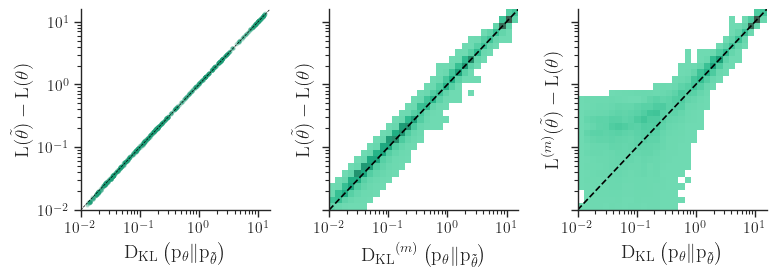

In [209]:
bins = torch.linspace(-2, 1.2, 31)
xs = [10**bins.min(), 10**bins.max()]
_, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharex=False, sharey=False)

kl_div_mean_label = r"$\kld{\prob_{\theta}}{\prob_{\tilde{\theta}}}$"
kl_div_sample_label = r"$\kl^{(m)}\left(\prob_{\theta}\|\prob_{\tilde{\theta}}\right)$"
cross_entropy_delta_mean_label = r"$\mathrm{L}(\tilde{\theta}) - \mathrm{L}(\theta)$"
cross_entropy_delta_sample_label = r"$\mathrm{L}^{(m)}(\tilde{\theta}) - \mathrm{L}(\theta)$"

sns.scatterplot(data=df.sample(1000, random_state=np.random.default_rng(10)), x="kl_div_mean", y="cross_entropy_delta_mean",
                lw=0, alpha=.25, ax=ax0)
ax0.plot(xs, xs, "k--", lw=0.5)
ax0.set_xscale("log")
ax0.set_yscale("log")
ax0.set_xlabel(kl_div_mean_label)
ax0.set_ylabel(cross_entropy_delta_mean_label)

sns.histplot(data=df[df.metric == "kl_div"], x="sample", y="cross_entropy_delta_mean", log_scale=True,
             bins=(bins, bins), ax=ax1)
ax1.plot(xs, xs, "k--")
ax1.tick_params(labelleft=False)
ax1.set_xlabel(kl_div_sample_label)
ax1.set_ylabel(cross_entropy_delta_mean_label)

sns.histplot(data=df[df.metric == "cross_entropy_delta"], y="sample", x="kl_div_mean", log_scale=True,
             bins=(bins, bins), ax=ax2)
ax2.plot(xs, xs, "k--")
ax2.tick_params(labelleft=False)
ax2.set_xlabel(kl_div_mean_label)
ax2.set_ylabel(cross_entropy_delta_sample_label)

for ax in [ax0, ax1, ax2]:
    ax.set_xlim(xs)
    ax.set_ylim(xs)
    ax.tick_params(which="minor", left=True, bottom=True)
    ax.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0, subs=range(2, 10), numticks=100))
    ax.xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=100))

plot_utils.tidy(ax0.figure)
plot_utils.save("xp_kl_vs_cross_entropy")